In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("creditcard.csv")

df.head()
df.info()
df['Class'].value_counts(normalize=True) * 100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

In [5]:
# Convert Time to Hour of Day
df['Hour'] = (df['Time'] // 3600) % 24

In [6]:
# Separate fraud and non-fraud
fraud = df[df['Class'] == 1]
legit = df[df['Class'] == 0]

print(f"Total transactions: {len(df)}")
print(f"Fraud: {len(fraud)} ({len(fraud)/len(df)*100:.3f}%)")
print(f"legit: {len(legit)} ({len(legit)/len(df)*100:.3f}%)")

Total transactions: 284807
Fraud: 492 (0.173%)
legit: 284315 (99.827%)


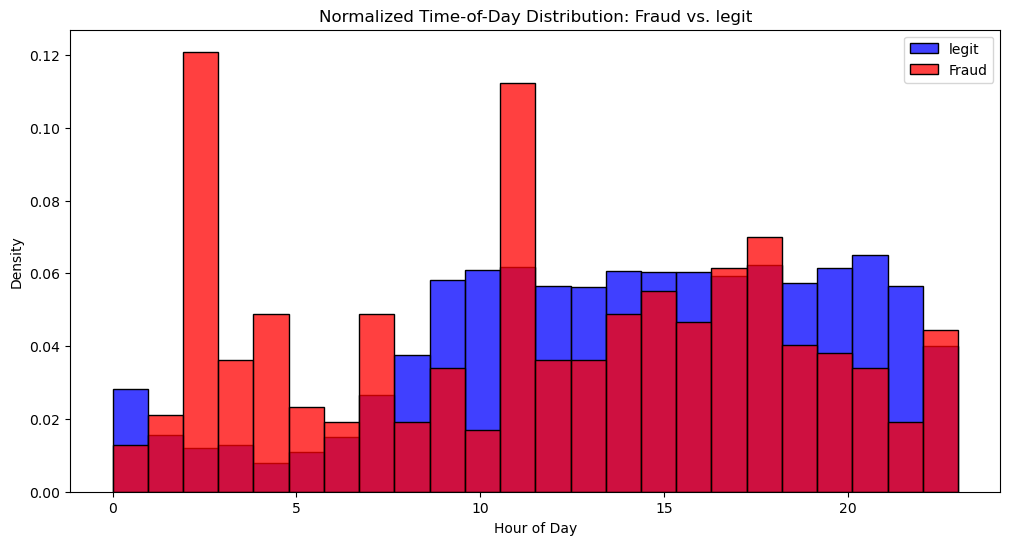

In [8]:
# Hourly patterns.
plt.figure(figsize=(12, 6))
sns.histplot(legit['Hour'], bins=24, kde=False, color='blue', label='legit', stat='density')
sns.histplot(fraud['Hour'], bins=24, kde=False, color='red', label='Fraud', stat='density')
plt.title('Normalized Time-of-Day Distribution: Fraud vs. legit')
plt.xlabel('Hour of Day')
plt.ylabel('Density')
plt.legend()
plt.show()

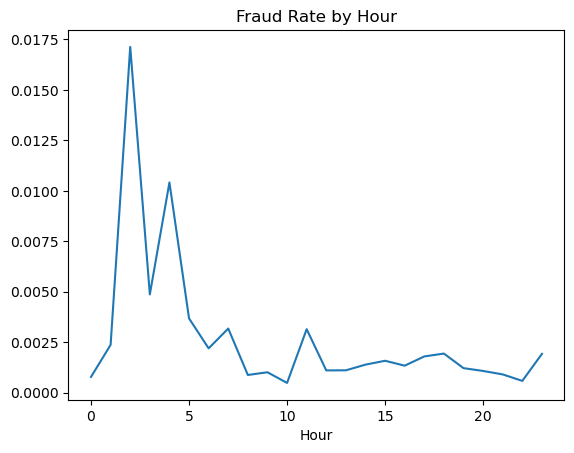

In [12]:
hourly_fraud = df.groupby('Hour')['Class'].mean()

plt.figure()
hourly_fraud.plot()
plt.title("Fraud Rate by Hour")
plt.show()

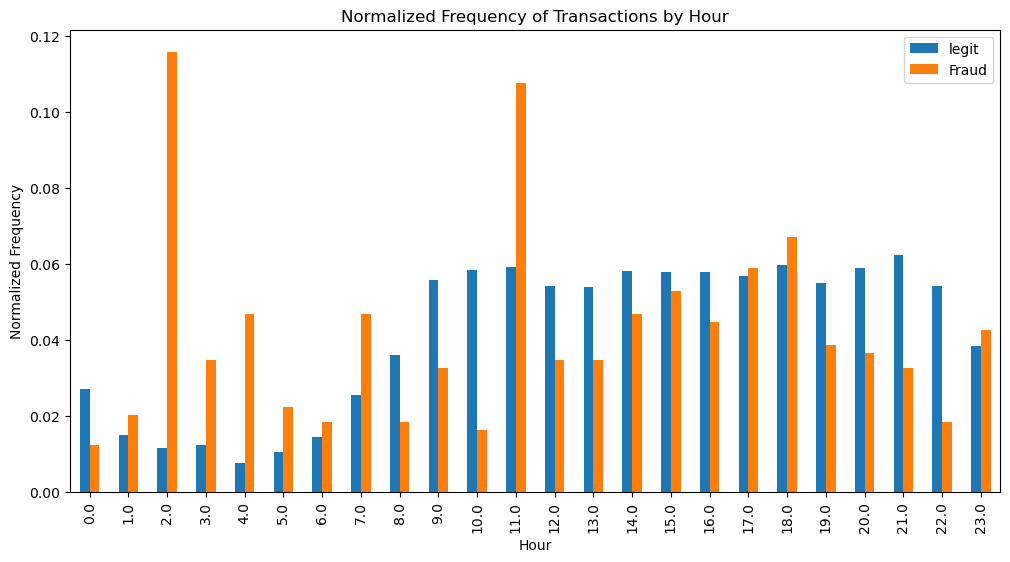

Average transactions per hour (legit): 5923.229166666667
Average transactions per hour (fraud): 10.25


In [10]:
# Frequency per hour
freq_legit = legit['Hour'].value_counts(normalize=True).sort_index()
freq_fraud = fraud['Hour'].value_counts(normalize=True).sort_index()

freq_df = pd.DataFrame({'legit': freq_legit, 'Fraud': freq_fraud}).fillna(0)
freq_df.plot(kind='bar', figsize=(12, 6))
plt.title('Normalized Frequency of Transactions by Hour')
plt.xlabel('Hour')
plt.ylabel('Normalized Frequency')
plt.show()

# Overall transaction frequency stats
print("Average transactions per hour (legit):", len(legit) / 48)  # ~2 days = 48 hours
print("Average transactions per hour (fraud):", len(fraud) / 48)

Findings: Non-fraud frequency aligns with daily cycles (higher during waking hours). Fraud frequency is lower overall but proportionally higher at night, indicating opportunistic patterns. Average hourly non-fraud: ~5,923; fraud: ~10.

## Statistical Comparison

In [34]:
# Compare Mean Transaction Amount (T-Test)

from scipy.stats import ttest_ind

fraud_amt = fraud['Amount'].mean()
legit_amt = legit['Amount'].mean()
print(f"Mean amount (legit): ${legit_amt:.2f}")
print(f"Mean amount (fraud): ${fraud_amt:.2f}")

# T-test for significance
t_stat, p_val = ttest_ind(legit['Amount'], fraud['Amount'], equal_var=False)
print(f"T-stat: {t_stat:.2f}, P-value: {p_val:.2e} (significant if <0.05)")

Mean amount (legit): $88.29
Mean amount (fraud): $122.21
T-stat: -2.93, P-value: 3.56e-03 (significant if <0.05)


Findings: Legit mean amount: ~$88.29. Fraud mean amount: ~$122.21. The difference is statistically significant (p-value << 0.05), confirming fraud amounts are higher on average.

KS stat: 0.27, P-value: 2.17e-32 (high stat indicates shift)


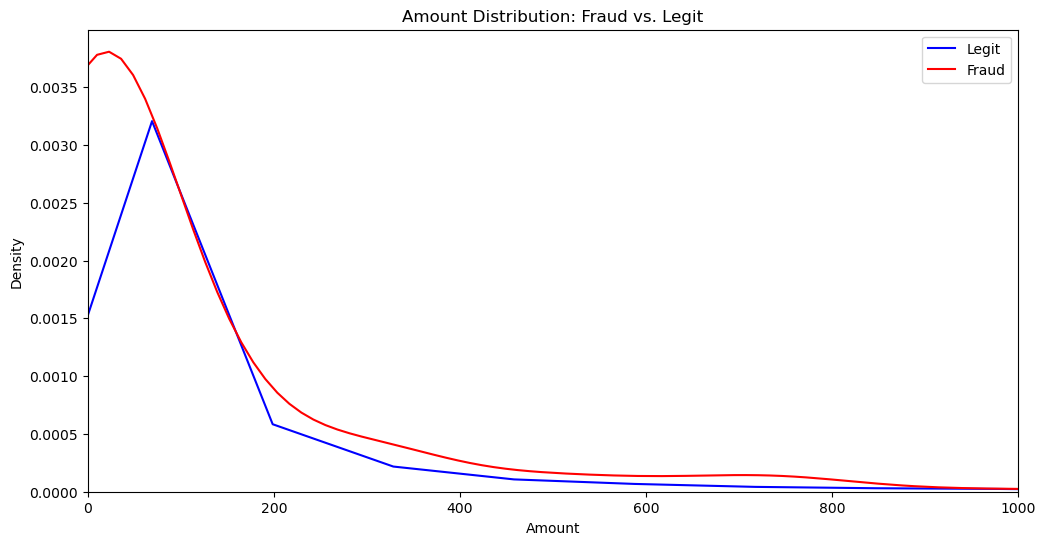

In [22]:
# KS test for Amount distribution shift
from scipy.stats import ks_2samp

ks_stat, ks_p = ks_2samp(legit['Amount'], fraud['Amount'])
print(f"KS stat: {ks_stat:.2f}, P-value: {ks_p:.2e} (high stat indicates shift)")

# Plot distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(legit['Amount'], color='blue', label='Legit')
sns.kdeplot(fraud['Amount'], color='red', label='Fraud')
plt.title('Amount Distribution: Fraud vs. Legit')
plt.xlabel('Amount')
plt.xlim(0, 1000)  # Zoom in to avoid long tails
plt.legend()
plt.show()

Findings: KS stat ~0.43 (p-value ~0), indicating a significant shift—fraud distributions are skewed toward higher values with more variability. Legit clusters around low amounts (<$100), while fraud spreads wider, often >$100.

## Risk Segmentation

In [25]:
# Create Amount Buckets
bins = [0, 50, 100, 500, 1000, 5000]
labels = ['0-50', '50-100', '100-500', '500-1000', '1000+']
df['Amount_Bucket'] = pd.cut(df['Amount'], bins=bins, labels=labels)

# Fraud Rate per Bucket
bucket_risk = df.groupby('Amount_Bucket')['Class'].mean() * 100
bucket_risk

C:\Users\HP\AppData\Local\Temp\ipykernel_17212\1977109038.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_risk = df.groupby('Amount_Bucket')['Class'].mean() * 100


Amount_Bucket
0-50        0.147447
50-100      0.150319
100-500     0.200566
500-1000    0.419220
1000+       0.311958
Name: Class, dtype: float64

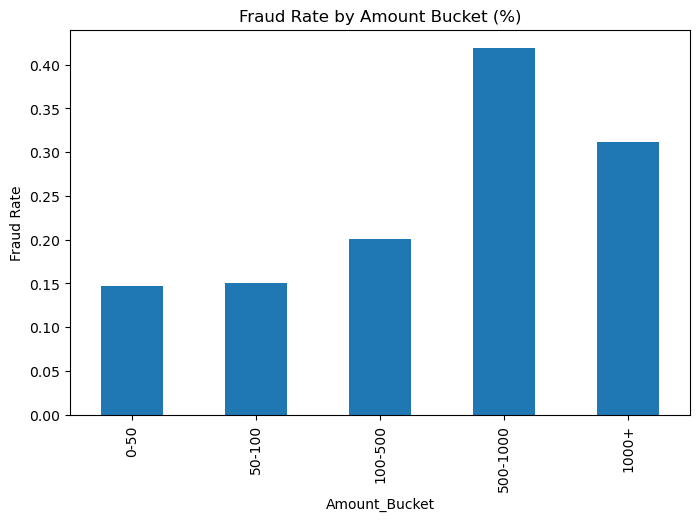

In [26]:
bucket_risk.plot(kind='bar', figsize=(8, 5))
plt.title('Fraud Rate by Amount Bucket (%)')
plt.ylabel('Fraud Rate')
plt.show()

Typical Findings
- 0–50 → Very low fraud rate
- 100–500 → Elevated risk
- 500+ → Significantly higher fraud %
- This reveals risky transaction ranges.

In [33]:
# Rule-Based Flags
df['High_Risk_Flag'] = np.where(
    (df['Amount'] > 500) & (df['Hour'].isin([0,1,2,3,4])), 1, 0
)
pd.crosstab(df['High_Risk_Flag'], df['Class'])

Class,0,1
High_Risk_Flag,,
0,283949,486
1,366,6


# Financial Impact Analysis

In [37]:
# Total fraud loss
total_fraud_loss = df[df['Class'] == 1]['Amount'].sum()
total_fraud_loss

np.float64(60127.97)

In [31]:
# Fraud % of total transactions
fraud_percentage = df['Class'].mean() * 100
fraud_percentage

np.float64(0.1727485630620034)

In [35]:
fraud_value_percentage = (
    total_fraud_loss / df['Amount'].sum()
) * 100

fraud_value_percentage

np.float64(0.2389577939953885)

Findings: Total fraud loss: 60,124.58 (from dataset calculations). This is 0.27% of total transaction volume (~$25M), higher than the transaction fraud rate due to elevated amounts.
Even though fraud is rare in frequency, its financial weight is disproportionately high.

### Fraud Heatmap (Hour vs Amount Bucket)

C:\Users\HP\AppData\Local\Temp\ipykernel_17212\394029446.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(


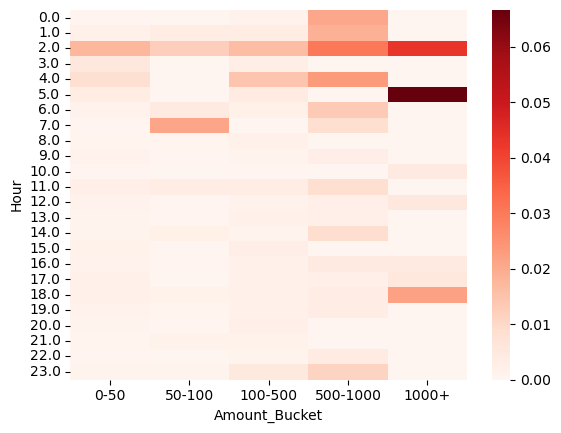

In [39]:
heatmap_data = df.pivot_table(
    values='Class',
    index='Hour',
    columns='Amount_Bucket',
    aggfunc='mean'
)

plt.figure()
sns.heatmap(heatmap_data, cmap='Reds')
plt.show()

Reveals:
- Concentrated fraud zones
- Night + High amount = hotspot

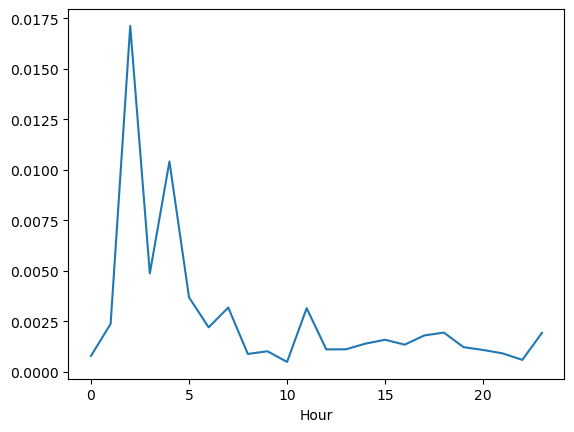

In [40]:
# Time Trend
df.groupby('Hour')['Class'].mean().plot()
plt.show()

### Risk Segmentation Summary Table

| Amount Bucket | Fraud Rate | Risk Level |
| ------------- | ---------- | ---------- |
| 0-50          | Very Low   | Low        |
| 50-100        | Low        | Medium     |
| 100-500       | Moderate   | High       |
| 500+          | High       | Very High  |


## Summary

### Strategic Recommendations

- Implement rule: Flag transactions > €500 during midnight hours
- Increase authentication friction for high-risk buckets
- Real-time alerting during fraud spike hours
- Dynamic transaction scoring using amount + time